In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

2024-04-23 15:59:02.351785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 15:59:02.351888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 15:59:02.536327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [4]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [5]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
Y_train = train['label']
X_train = train.drop(labels = ['label'], axis=1)


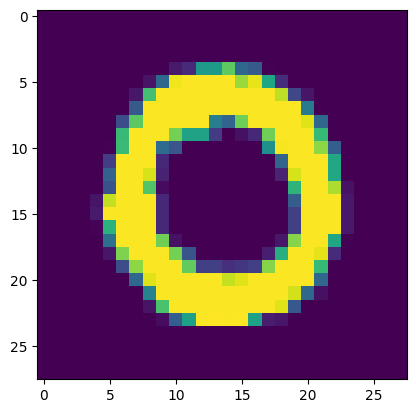

In [7]:
sample1 = np.reshape(X_train.iloc[1,:].values, (28,28))
plt.imshow(sample1)

**Preprocess the data**

In [8]:
X_train = X_train / 255.0
test = test/ 255.0

In [9]:
X_train.shape

(42000, 784)

In [10]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [11]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [12]:
X_train, X_val, Y_train, Y_val, = train_test_split(X_train, Y_train, test_size = .1, random_state=2)

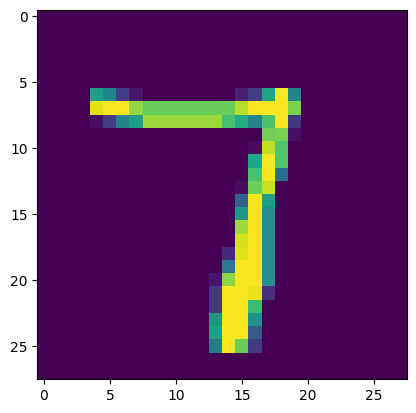

In [13]:
g = plt.imshow(X_train[1][:,:,0])

In [14]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation = 'softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
from keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
epochs = 10
batch_size = 86

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range 
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally 
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [19]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    verbose=2,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713887971.642939      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713887971.661054      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713887981.221279      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713887991.436112      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 - 30s - 69ms/step - accuracy: 0.8607 - loss: 0.4292 - val_accuracy: 0.9774 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 2/10


W0000 00:00:1713887992.472317      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:97: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


439/439 - 0s - 543us/step - accuracy: 0.9419 - loss: 0.1284 - val_accuracy: 0.9779 - val_loss: 0.0756 - learning_rate: 0.0010
Epoch 3/10
439/439 - 13s - 29ms/step - accuracy: 0.9616 - loss: 0.1289 - val_accuracy: 0.9850 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 4/10
439/439 - 0s - 631us/step - accuracy: 0.9767 - loss: 0.1582 - val_accuracy: 0.9855 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 5/10
439/439 - 13s - 29ms/step - accuracy: 0.9724 - loss: 0.0956 - val_accuracy: 0.9860 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 6/10
439/439 - 0s - 625us/step - accuracy: 0.9767 - loss: 0.1065 - val_accuracy: 0.9876 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 7/10
439/439 - 13s - 29ms/step - accuracy: 0.9761 - loss: 0.0789 - val_accuracy: 0.9907 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 8/10
439/439 - 0s - 622us/step - accuracy: 0.9884 - loss: 0.0268 - val_accuracy: 0.9907 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 9/10
439/439 - 13s - 30ms/step - accuracy: 0.9

116/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1713888045.937757      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


W0000 00:00:1713888046.455525      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


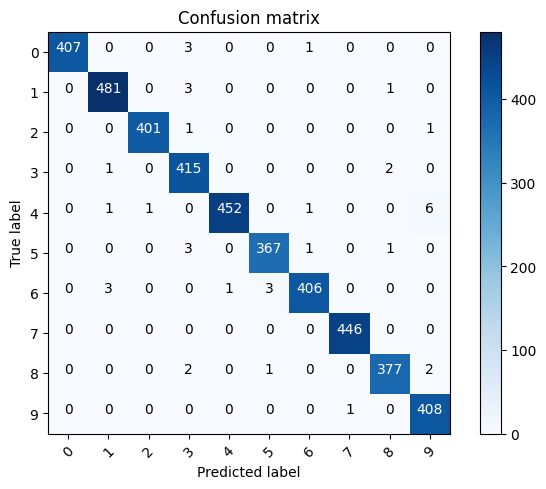

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Y_pred = model.predict(X_val)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(10)) 